## Modele

Dane niezbędne do prawidłowego funkcjonowania modelu przygotowywane są dzięki wykorzystaniu mechanizmu `pipeline` z biblioteki `sklearn`. Do wyboru cech (proces ich wybierania przebiega analogicznie jak ten zdefiniowany w *preprocessing_03.ipynb*) służy klasa **FeatureBuilder**. Następnie atrybuty są odpowiednio przetwarzane przez **Preprocessor** - uzupełnia on brakujące wartości i koduje atrybuty. 

#### Setup

In [88]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
from sklearn.pipeline import Pipeline
from src.builder import FeatureBuilder
from src.preprocessor import Preprocessor

#### Wczytanie i przygotwanie odpowiednich danych do pipeline'u ML i ewaluacji modelu 

In [90]:
import pandas as pd
from src.transformations.target import convert_price_to_number
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import HDBSCAN
import numpy as np

listings = pd.read_csv("../data/listings.csv")
sessions = pd.read_csv("../data/sessions.csv")
target = convert_price_to_number(listings["price"])
listings.drop(columns=["price"], inplace=True)

coords_rad = np.radians(listings[["latitude", "longitude"]].to_numpy())
clusterer = HDBSCAN(
    min_cluster_size=15,
    min_samples=3,
    metric="haversine",
    cluster_selection_method="eom",
    copy=False,
)
ids = clusterer.fit_predict(coords_rad)

X = listings
y = target
cv = KFold(n_splits=5, shuffle=True, random_state=13)

#### Model bazowy - regresja liniowa

In [91]:
from sklearn.linear_model import LinearRegression

pipe = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("regressor", LinearRegression()),
    ]
)

cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

pipe.fit(X, y)

print(f"Mean CV MAE: {mae.mean():.2f} ± {mae.std():.2f}")

Mean CV MAE: 38.78 ± 1.51


<Figure size 2000x1000 with 0 Axes>

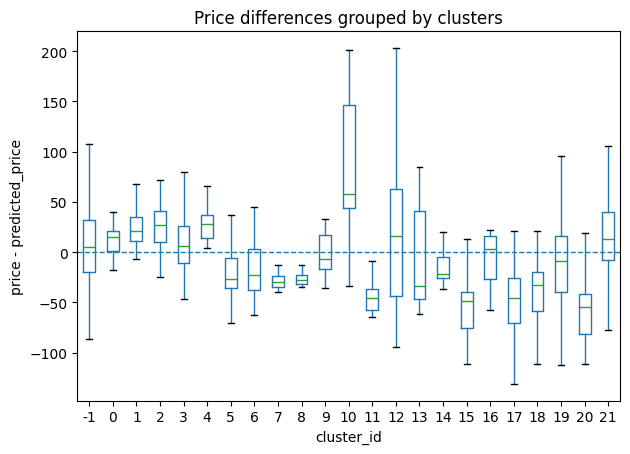

In [92]:
from src.visualizations.results import visualize_results, visualize_map

predictions = pipe.predict(X)
diff = y - predictions
visualize_results(diff, ids)

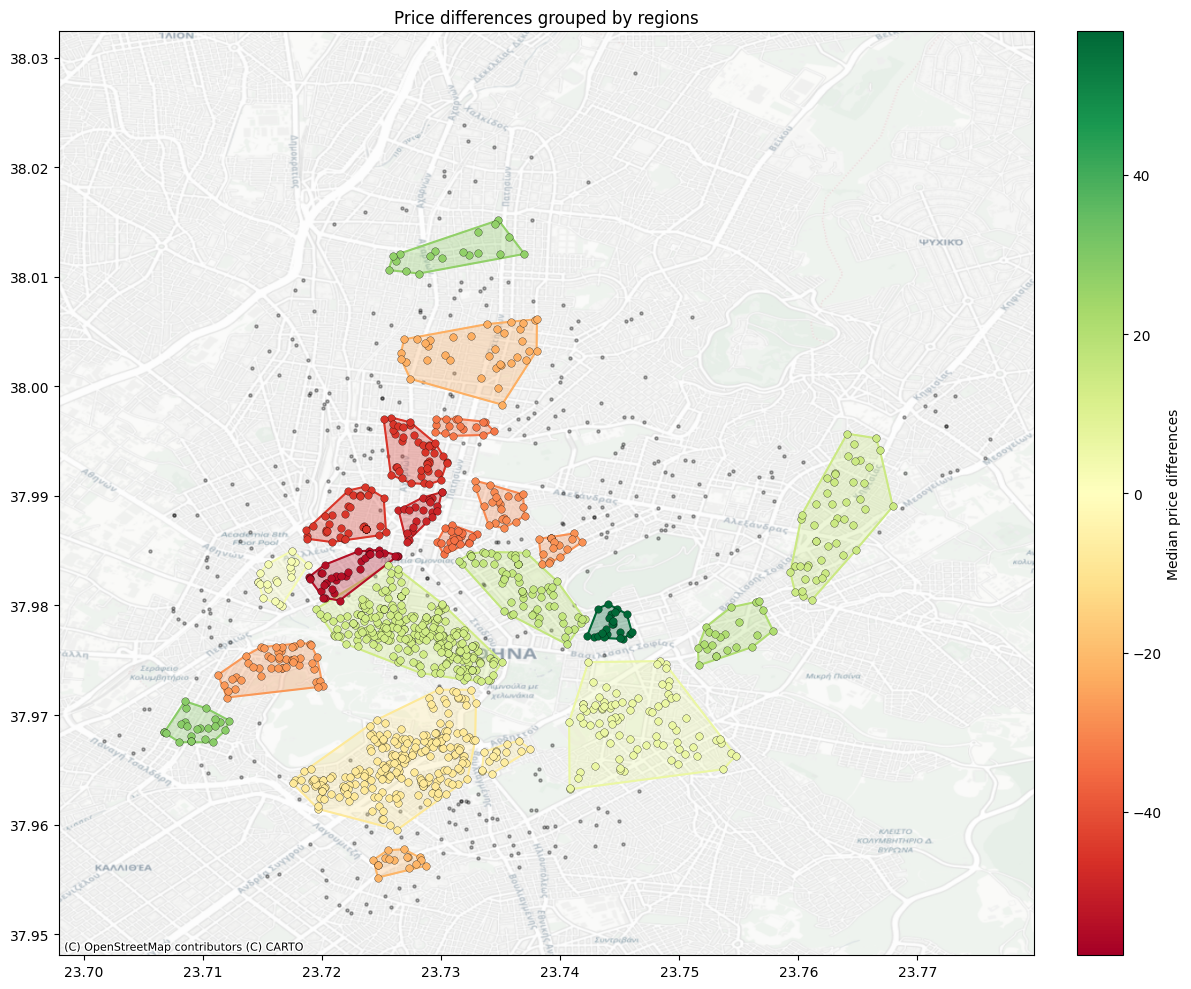

In [93]:
visualize_map(diff, ids, listings)

#### Model docelowy - random forest

In [94]:
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("regressor", RandomForestRegressor(n_estimators=100, n_jobs=-1)),
    ]
)

cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

print(f"Mean CV MAE: {mae.mean():.2f} ± {mae.std():.2f}")

Mean CV MAE: 34.25 ± 1.56
